In [1]:
%cd ../..

/Users/hellyshah/Documents/FUAS/Courses/HIS Project/Jupyter Notebooks/modern_timeseries


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
#import sys
#import os
#sys.path.append(os.path.abspath('../../')) # added to get correct file tree to fetch src.utils
import numpy as np
import pandas as pd
import time
import plotly.express as px
import plotly.graph_objects as go
import os
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path
from tqdm.autonotebook import tqdm
import warnings
import humanize

#If importing darts is throwing an error, import torch beforehand and then import darts
import torch
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveMean,
    NaiveDrift,
    ExponentialSmoothing,
    AutoARIMA,
    ARIMA,
    Theta,
    FFT
)

from darts.metrics import mase, mse, mae, ope

from src.utils.ts_utils import forecast_bias
from src.utils.general import LogTime
from src.utils import plotting_utils
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

#No module error for humanize and darts
#ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


#Solution : install humanize and darts
# pip install --force-reinstall pandas==2.1.4 
# pip install --force-reinstall numpy==1.26.3

/var/folders/fj/r6wgbnzj0h11qb_f4_10p_rw0000gn/T/ipykernel_1560/666263933.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")

In [4]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 20
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [5]:
#Reading the missing value imputed and train test split data
try:
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed.parquet")
    val_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed.parquet")
    test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Setting up Experiment Harness.ipynb in Chapter04
    </div>
    """))

In [6]:
len(train_df.LCLid.unique()) #as we have selected 150 samples 50 from each ACORN group

150

In [15]:
#picking a single time series from the dataset for illustration
#In our data, we have many households, to get a single time series, we are selecting one particular household
#as we did previously, setting the index to timestamp and having pandas data structure series

freq = train_df.iloc[0]['frequency']
ts_train = train_df.loc[train_df.LCLid=="MAC000193", ["timestamp","energy_consumption"]].set_index("timestamp")
ts_val = val_df.loc[val_df.LCLid=="MAC000193", ["timestamp","energy_consumption"]].set_index("timestamp")
ts_test = test_df.loc[test_df.LCLid=="MAC000193", ["timestamp","energy_consumption"]].set_index("timestamp")

# Baseline Forecasts

In [16]:
pred_df = pd.concat([ts_train, ts_val])
metric_record = []

ts_train = TimeSeries.from_series(ts_train) #darts.TimeSeries data structure using pandas from series
ts_val = TimeSeries.from_series(ts_val)
ts_test = TimeSeries.from_series(ts_test)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/darts/metrics/metrics.py:979: RuntimeWarning: Mean of empty slice
  return np.nanmean(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/darts/metrics/metrics.py:370: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)


nan

In [20]:
def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)                   #model.fit trains the model using our training dataset
    y_pred = model.predict(len(ts_test))   
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred), #mae,mse,mase are darts inbuilt methods
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(actual_series = ts_test, pred_series = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred
    

In [21]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    # colors = ["rgba("+",".join([str(c) for c in plotting_utils.hex_to_rgb(c)])+",<alpha>)" for c in px.colors.qualitative.Plotly]
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    # colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Safe]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].energy_consumption,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

## Naive Forecast

In [22]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pred_df.join(y_pred)


#boolean array argument obj to delete must be one dimensional and match the axis length of 1488

Time Elapsed: 0 microseconds


ValueError: boolean array argument obj to delete must be one dimensional and match the axis length of 1488

In [28]:
fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig = format_plot(fig, title=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/naive.png")
fig.show()

KeyError: 'naive_predictions'

## Moving Average Forecast

In [29]:
from src.forecasting.baselines import NaiveMovingAverage

In [30]:
name = "Moving Average Forecast"
naive_model = NaiveMovingAverage(window=48)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "moving_average_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


ValueError: boolean array argument obj to delete must be one dimensional and match the axis length of 1488

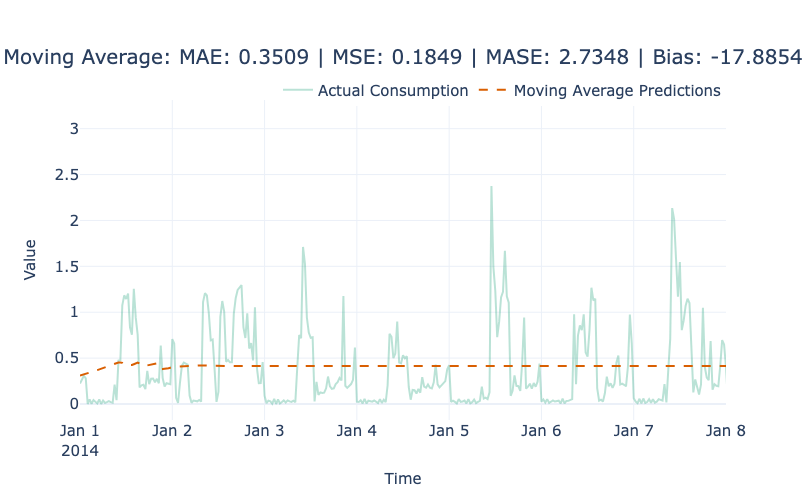

In [20]:
fig = plot_forecast(pred_df, forecast_columns=["moving_average_predictions"], forecast_display_names=['Moving Average Predictions'])
fig = format_plot(fig, title=f"Moving Average: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/ma.png")
fig.show()

In [21]:
# fig = plot_forecast(pred_df, 
#                     forecast_columns=[
#                         "naive_predictions",
#                         "moving_average_predictions"
#                     ], 
#                     forecast_display_names=[
#                         "Naive",
#                         'Moving Average'
#                     ])
# fig = format_plot(fig, title=f"Naive and Moving Average Forecasts")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# # fig = plotting_utils.make_lines_greyscale(fig)
# fig.write_image("imgs/chapter_4/naive_ma.png")
# fig.show()

## Seasonal Naive Forecast

In [22]:
name = "Seasonal Naive Forecast"
naive_model = NaiveSeasonal(K=48*7)
with LogTime() as timer:
    y_pred, metrics = eval_model(naive_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "snaive_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


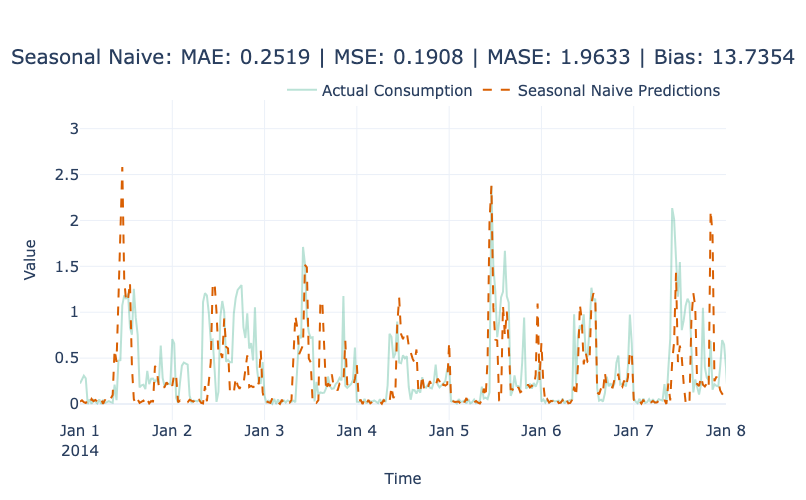

In [23]:
fig = plot_forecast(pred_df, forecast_columns=["snaive_predictions"], forecast_display_names=['Seasonal Naive Predictions'])
fig = format_plot(fig, title=f"Seasonal Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/snaive.png")
fig.show()

In [24]:
# fig = plot_forecast(pred_df, forecast_columns=["snaive_predictions"], forecast_display_names=['Seasonal Naive Predictions'])
# fig = format_plot(fig, title=f"Seasonal Naive Forecasts")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# # fig = plotting_utils.make_lines_greyscale(fig)
# fig.write_image("imgs/chapter_4/snaive.png")
# fig.show()

## Exponential Smoothing Forecast

In [25]:
from darts.utils.utils import ModelMode, SeasonalityMode

In [26]:
name = "Exponential Smoothing"
# Suppress FutureWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ets_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=True, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=48*7, random_state=42)
    with LogTime() as timer:
        y_pred, metrics = eval_model(ets_model, ts_train, ts_val, name=name)
    metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pred_df.join(y_pred)

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v2\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Time Elapsed: 19 seconds


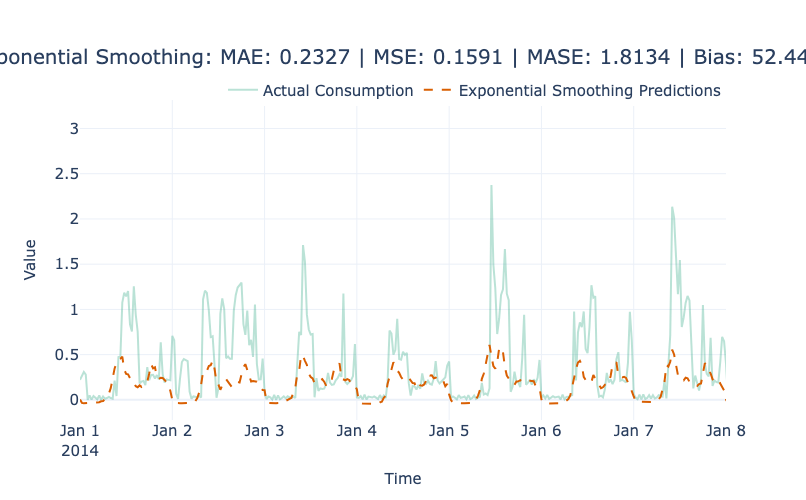

In [27]:
fig = plot_forecast(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])
fig = format_plot(fig, title=f"Exponential Smoothing: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/ets.png")
fig.show()

## ARIMA

In [28]:
name = "ARIMA"
#Not using AutoARIMA because it just takes too much time for long time series
# arima_model = AutoARIMA(max_p=5, max_q=3, m=48, seasonal=False)
arima_model = ARIMA(p=2, d=1, q=1, seasonal_order=(1, 1, 1, 48))
# Taking only latest 8000 points for training (Time constraints)
# Reduce 8000 if it is taking too much time or consuming all the memory
with LogTime() as timer:
    y_pred, metrics = eval_model(arima_model, ts_train[-8000:], ts_val,  name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "arima_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 3 minutes and 32 seconds


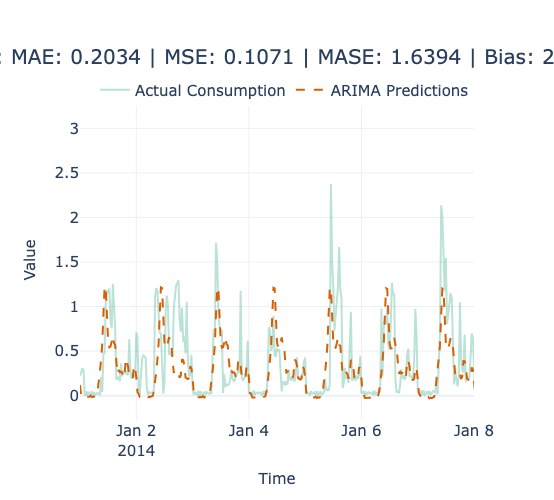

In [29]:
fig = plot_forecast(pred_df, forecast_columns=["arima_predictions"], forecast_display_names=['ARIMA Predictions'])
fig = format_plot(fig, title=f"ARIMA: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/arima.png")
fig.show()

In [30]:
# fig = plot_forecast(pred_df, 
#                     forecast_columns=[
#                         "ets_predictions",
#                         "arima_predictions"
#                     ], 
#                     forecast_display_names=[
#                         "ETS",
#                         'ARIMA'
#                     ])
# fig = format_plot(fig, title=f"ETS and ARIMA Forecasts")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# # fig = plotting_utils.make_lines_greyscale(fig)
# fig.write_image("imgs/chapter_4/ets_arima.png")
# fig.show()

## Theta

In [31]:
name = "Theta"
theta_model = Theta(theta=3, seasonality_period=48*7, season_mode=SeasonalityMode.ADDITIVE)
with LogTime() as timer:
    y_pred, metrics = eval_model(theta_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


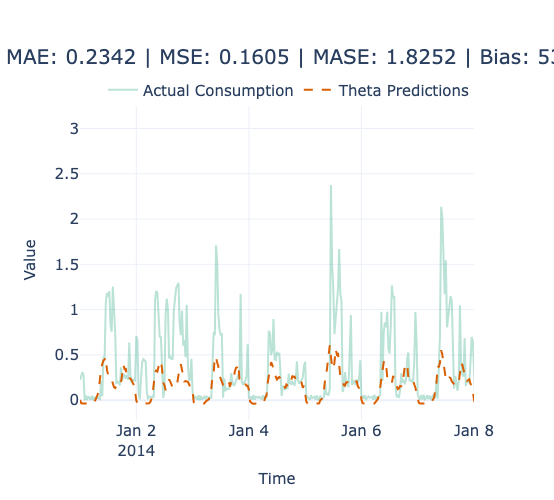

In [32]:
fig = plot_forecast(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])
fig = format_plot(fig, title=f"Theta: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/theta.png")
fig.show()

## FFT

In [33]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
with LogTime() as timer:
    y_pred, metrics = eval_model(fft_model, ts_train, ts_val, name=name)
metrics['Time Elapsed'] = timer.elapsed
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


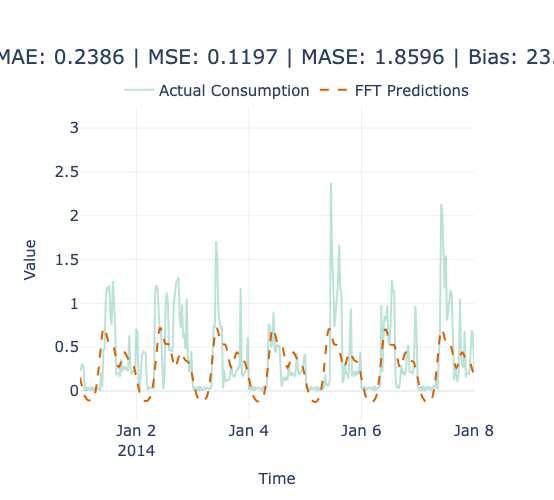

In [34]:
fig = plot_forecast(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])
fig = format_plot(fig, title=f"FFT: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_4/fft.png")
fig.show()

In [35]:
# fig = plot_forecast(pred_df, 
#                     forecast_columns=[
#                         "theta_predictions",
#                         "fft_predictions"
#                     ], 
#                     forecast_display_names=[
#                         "Theta",
#                         'FFT'
#                     ])
# fig = format_plot(fig, title=f"Theta and FFT Forecasts")
# fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
# # fig = plotting_utils.make_lines_greyscale(fig)
# fig.write_image("imgs/chapter_4/theta_fft.png")
# fig.show()

In [62]:
metric_styled = pd.DataFrame(metric_record).style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "MASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","MASE","Time Elapsed"])
display(metric_styled)

,Algorithm,MAE,MSE,MASE,Forecast Bias,Time Elapsed
0,Naive,0.305,0.249,2.380,74.34%,0.054280
1,Moving Average Forecast,0.351,0.185,2.735,-17.89%,0.088252
2,Seasonal Naive Forecast,0.252,0.191,1.963,13.74%,0.034999
3,Exponential Smoothing,0.233,0.159,1.813,52.45%,19.906754
4,ARIMA,0.203,0.107,1.639,24.00%,227.578508
5,Theta,0.234,0.160,1.825,53.71%,0.188577
6,FFT,0.239,0.120,1.860,23.15%,0.367810


Although ARIMA gives us the best metrics, it takes too long to run, even with a sampled timeseries.
We can see that Theta or FFT metrics are lower and doesn't take much time to run. So let's run Theta and FFT for all the consumers in blocks 0-7.

## Running Baseline Forecast for all consumers

In [13]:
lcl_ids = sorted(train_df.LCLid.unique())

### Forecasting for Validation Period

#### Theta Forecast

In [17]:
name = "Theta"
theta_preds = []
theta_metrics = []
with LogTime() as timer:
    for lcl_id in tqdm(lcl_ids):
        theta_model = Theta(theta=3, seasonality_period=48*7, season_mode=SeasonalityMode.ADDITIVE)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        # ts = TimeSeries.from_series(test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        y_pred, metrics = eval_model(theta_model, tr, vl, name=name)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        metrics["LCLid"] = lcl_id
        metrics['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        theta_preds.append(y_pred)
        theta_metrics.append(metrics)

  0%|          | 0/150 [00:00<?, ?it/s]

Time Elapsed: 56 seconds


In [18]:
theta_val_pred_df = pd.concat(theta_preds)
theta_val_pred_df.head()

,predictions,LCLid,Algorithm,energy_consumption
time,,,,
2014-01-01 00:00:00,0.157925,MAC000061,Theta,0.165
2014-01-01 00:30:00,0.150391,MAC000061,Theta,0.167
2014-01-01 01:00:00,0.147510,MAC000061,Theta,0.150
2014-01-01 01:30:00,0.146589,MAC000061,Theta,0.091
2014-01-01 02:00:00,0.147600,MAC000061,Theta,0.047


In [19]:
theta_val_metric_df = pd.DataFrame(theta_metrics)
theta_val_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Theta,0.106322,0.014634,3.042717,-79.891534,MAC000061
1,Theta,0.073899,0.029905,0.981517,1.781356,MAC000062
2,Theta,0.071261,0.017072,1.845224,-12.616546,MAC000066
3,Theta,0.136424,0.026904,1.587318,-13.788588,MAC000086
4,Theta,0.130471,0.029257,1.978130,-50.958936,MAC000126


In [20]:
actual_series = TimeSeries.from_values(theta_val_pred_df.energy_consumption.values)
pred_series = TimeSeries.from_values(theta_val_pred_df.predictions.values)

In [21]:
overall_metrics_val_theta = {
    "Algorithm": "Theta",
    "MAE": mae(actual_series = actual_series, pred_series = pred_series),
    "MSE": mse(actual_series = actual_series, pred_series = pred_series),
    "meanMASE": theta_val_metric_df.MASE.mean(),
    "Forecast Bias": ope(actual_series = actual_series, pred_series = pred_series)
}
overall_metrics_val_theta

{'Algorithm': 'Theta',
 'MAE': 0.1559833190163672,
 'MSE': 0.07819327321004789,
 'meanMASE': 2.025959903214256,
 'Forecast Bias': 1.9636525477287972}

#### FFT

In [22]:
name = "FFT"
fft_preds = []
fft_metrics = []
with LogTime() as timer:
    for lcl_id in tqdm(lcl_ids):
        fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
        tr = TimeSeries.from_series(train_df.loc[train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        vl = TimeSeries.from_series(val_df.loc[val_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        # ts = TimeSeries.from_series(test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
        y_pred, metrics = eval_model(fft_model, tr, vl, name=name)
        y_pred = format_y_pred(y_pred, "predictions").to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = name
        metrics["LCLid"] = lcl_id
        metrics['Algorithm'] = name
        y_pred['energy_consumption'] = vl.data_array().to_series().values
        fft_preds.append(y_pred)
        fft_metrics.append(metrics)

  0%|          | 0/150 [00:00<?, ?it/s]

Time Elapsed: 1 minute and 45 seconds


In [23]:
fft_val_pred_df = pd.concat(fft_preds)
fft_val_pred_df.head()

,predictions,LCLid,Algorithm,energy_consumption
time,,,,
2014-01-01 00:00:00,0.111663,MAC000061,FFT,0.165
2014-01-01 00:30:00,0.088207,MAC000061,FFT,0.167
2014-01-01 01:00:00,0.070980,MAC000061,FFT,0.150
2014-01-01 01:30:00,0.060706,MAC000061,FFT,0.091
2014-01-01 02:00:00,0.056753,MAC000061,FFT,0.047


In [24]:
fft_val_metric_df = pd.DataFrame(fft_metrics)
fft_val_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,FFT,0.051133,0.005359,1.463327,-15.981921,MAC000061
1,FFT,0.088674,0.031104,1.177767,-8.554056,MAC000062
2,FFT,0.077504,0.016847,2.006894,-21.332518,MAC000066
3,FFT,0.119568,0.026057,1.391193,20.501475,MAC000086
4,FFT,0.089382,0.026061,1.355154,14.736586,MAC000126


In [25]:
actual_series = TimeSeries.from_values(fft_val_pred_df.energy_consumption.values)
pred_series = TimeSeries.from_values(fft_val_pred_df.predictions.values)

In [26]:
overall_metrics_val_fft = {
    "Algorithm": "FFT",
    "MAE": mae(actual_series = actual_series, pred_series = pred_series),
    "MSE": mse(actual_series = actual_series, pred_series = pred_series),
    "meanMASE": fft_val_metric_df.MASE.mean(),
    "Forecast Bias": ope(actual_series = actual_series, pred_series = pred_series)
}
overall_metrics_val_fft

{'Algorithm': 'FFT',
 'MAE': 0.12559473121140635,
 'MSE': 0.06355778732500984,
 'meanMASE': 1.6394064535040864,
 'Forecast Bias': 13.570502005564656}

#### Evaluation of Baseline Forecast

In [27]:
agg_val_metrics_df = pd.DataFrame([overall_metrics_val_fft, overall_metrics_val_theta])

display(agg_val_metrics_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]))

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,FFT,0.126,0.064,1.639,13.57%
1,Theta,0.156,0.078,2.026,1.96%


In [28]:
baseline_val_pred_df = pd.concat([theta_val_pred_df, fft_val_pred_df])

In [29]:
baseline_val_metrics_df = pd.concat([theta_val_metric_df, fft_val_metric_df])
baseline_val_metrics_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Theta,0.106322,0.014634,3.042717,-79.891534,MAC000061
1,Theta,0.073899,0.029905,0.981517,1.781356,MAC000062
2,Theta,0.071261,0.017072,1.845224,-12.616546,MAC000066
3,Theta,0.136424,0.026904,1.587318,-13.788588,MAC000086
4,Theta,0.130471,0.029257,1.978130,-50.958936,MAC000126


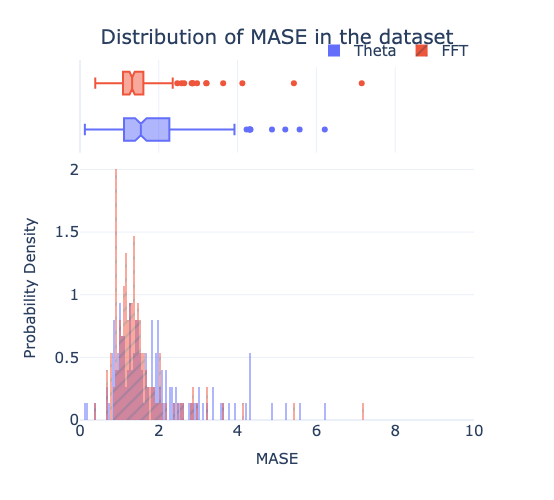

In [30]:
fig = px.histogram(baseline_val_metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,10])
fig.write_image("imgs/chapter_4/mase_dist.png")
fig.show()

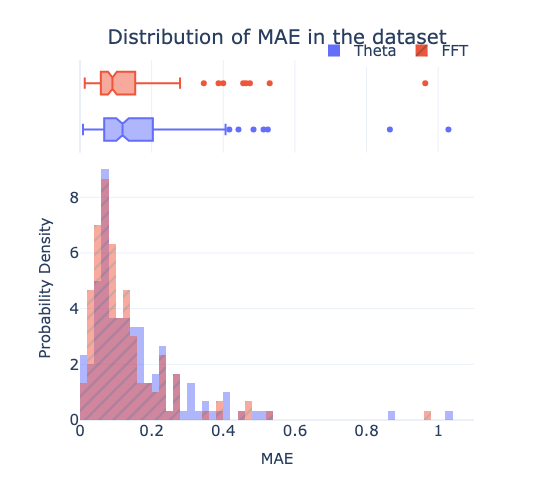

In [31]:
fig = px.histogram(baseline_val_metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.write_image("imgs/chapter_4/mae_dist.png")
fig.update_layout(xaxis_range=[0,1.1])
fig.show()

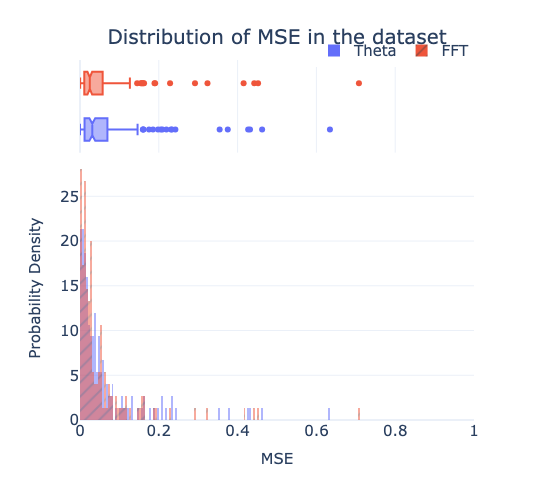

In [32]:
fig = px.histogram(baseline_val_metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,1])
fig.write_image("imgs/chapter_4/mse_dist.png")
fig.show()

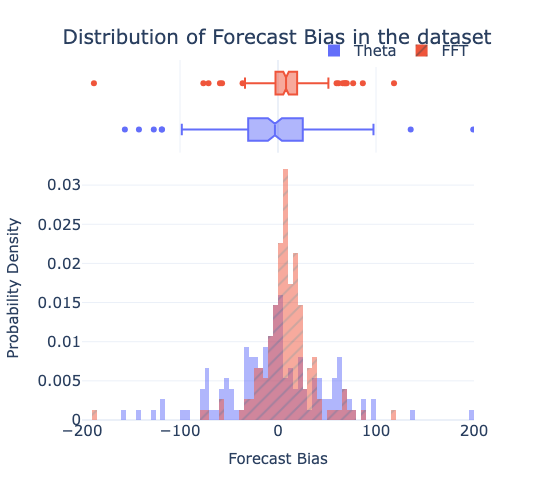

In [33]:
fig = px.histogram(baseline_val_metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-200,200])
fig.write_image("imgs/chapter_4/bias_dist.png")
fig.show()

#### Saving the Baseline Forecasts and Metrics

In [34]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [35]:
baseline_val_pred_df.to_pickle(output/"baseline_val_prediction_df.pkl")
baseline_val_metrics_df.to_pickle(output/"baseline_val_metrics_df.pkl")
agg_val_metrics_df.to_pickle(output/"baseline_val_aggregate_metrics.pkl")

### Forecasting for Test Period

In [36]:
_train_df = pd.concat([train_df, val_df])

#### Theta Forecast

In [37]:
name = "Theta"
theta_preds = []
theta_metrics = []
for lcl_id in tqdm(lcl_ids):
    theta_model = Theta(theta=3, seasonality_period=48*7, season_mode=SeasonalityMode.ADDITIVE)
    tr = TimeSeries.from_series(_train_df.loc[_train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    ts = TimeSeries.from_series(test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    y_pred, metrics = eval_model(theta_model, tr, ts, name=name)
    y_pred = format_y_pred(y_pred, "predictions").to_frame()
    y_pred['LCLid'] = lcl_id
    y_pred['Algorithm'] = name
    metrics["LCLid"] = lcl_id
    metrics['Algorithm'] = name
    y_pred['energy_consumption'] = ts.data_array().to_series().values
    theta_preds.append(y_pred)
    theta_metrics.append(metrics)

  0%|          | 0/150 [00:00<?, ?it/s]

In [38]:
theta_test_pred_df = pd.concat(theta_preds)
theta_test_pred_df.head()

,predictions,LCLid,Algorithm,energy_consumption
time,,,,
2014-02-01 00:00:00,0.020412,MAC000061,Theta,0.066
2014-02-01 00:30:00,0.002474,MAC000061,Theta,0.063
2014-02-01 01:00:00,-0.007651,MAC000061,Theta,0.040
2014-02-01 01:30:00,-0.009468,MAC000061,Theta,0.020
2014-02-01 02:00:00,-0.011249,MAC000061,Theta,0.018


In [39]:
theta_test_metric_df = pd.DataFrame(theta_metrics)
theta_test_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Theta,0.072221,0.008306,2.070804,44.759499,MAC000061
1,Theta,0.079236,0.027549,1.044934,-4.373358,MAC000062
2,Theta,0.041082,0.004326,1.058766,27.780123,MAC000066
3,Theta,0.131214,0.031771,1.470178,6.858161,MAC000086
4,Theta,0.067902,0.011998,1.026197,42.214746,MAC000126


In [40]:
actual_series = TimeSeries.from_values(theta_test_pred_df.energy_consumption.values)
pred_series = TimeSeries.from_values(theta_test_pred_df.predictions.values)

In [41]:
overall_metrics_test_theta = {
    "Algorithm": "Theta",
    "MAE": mae(actual_series = actual_series, pred_series = pred_series),
    "MSE": mse(actual_series = actual_series, pred_series = pred_series),
    "meanMASE": theta_test_metric_df.MASE.mean(),
    "Forecast Bias": ope(actual_series = actual_series, pred_series = pred_series)
}
overall_metrics_test_theta

{'Algorithm': 'Theta',
 'MAE': 0.144346251409469,
 'MSE': 0.08019775768313116,
 'meanMASE': 1.7537845196366413,
 'Forecast Bias': 14.636135945690581}

#### FFT

In [42]:
name = "FFT"
fft_preds = []
fft_metrics = []
for lcl_id in tqdm(lcl_ids):
    fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
    tr = TimeSeries.from_series(_train_df.loc[_train_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    ts = TimeSeries.from_series(test_df.loc[test_df.LCLid==lcl_id, ["timestamp","energy_consumption"]].set_index("timestamp"))
    y_pred, metrics = eval_model(fft_model, tr, ts, name=name)
    y_pred = format_y_pred(y_pred, "predictions").to_frame()
    y_pred['LCLid'] = lcl_id
    y_pred['Algorithm'] = name
    metrics["LCLid"] = lcl_id
    metrics['Algorithm'] = name
    y_pred['energy_consumption'] = ts.data_array().to_series().values
    fft_preds.append(y_pred)
    fft_metrics.append(metrics)

  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
fft_test_pred_df = pd.concat(fft_preds)
fft_test_pred_df.head()

,predictions,LCLid,Algorithm,energy_consumption
time,,,,
2014-02-01 00:00:00,0.113955,MAC000061,FFT,0.066
2014-02-01 00:30:00,0.087921,MAC000061,FFT,0.063
2014-02-01 01:00:00,0.068605,MAC000061,FFT,0.040
2014-02-01 01:30:00,0.056841,MAC000061,FFT,0.020
2014-02-01 02:00:00,0.051993,MAC000061,FFT,0.018


In [44]:
fft_test_metric_df = pd.DataFrame(fft_metrics)
fft_test_metric_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,FFT,0.055955,0.006037,1.604415,-20.035937,MAC000061
1,FFT,0.092507,0.028870,1.219943,-11.961699,MAC000062
2,FFT,0.127636,0.019598,3.289481,-182.771212,MAC000066
3,FFT,0.124985,0.030547,1.400379,18.559620,MAC000086
4,FFT,0.069909,0.010817,1.056535,-9.815365,MAC000126


In [45]:
actual_series = TimeSeries.from_values(fft_test_pred_df.energy_consumption.values)
pred_series = TimeSeries.from_values(fft_test_pred_df.predictions.values)

In [46]:
overall_metrics_test_fft = {
    "Algorithm": "FFT",
    "MAE": mae(actual_series = actual_series, pred_series = pred_series),
    "MSE": mse(actual_series = actual_series, pred_series = pred_series),
    "meanMASE": fft_test_metric_df.MASE.mean(),
    "Forecast Bias": ope(actual_series = actual_series, pred_series = pred_series)
}
overall_metrics_test_fft

{'Algorithm': 'FFT',
 'MAE': 0.11973840062430437,
 'MSE': 0.06032477752022654,
 'meanMASE': 1.540829842518397,
 'Forecast Bias': 0.14353171227097158}

### Evaluation of Baseline Forecast

In [47]:
agg_test_metrics_df = pd.DataFrame([overall_metrics_test_fft, overall_metrics_test_theta])

display(agg_test_metrics_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]))

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,FFT,0.120,0.060,1.541,0.14%
1,Theta,0.144,0.080,1.754,14.64%


In [48]:
baseline_test_pred_df = pd.concat([theta_test_pred_df, fft_test_pred_df])

In [49]:
baseline_test_metrics_df = pd.concat([theta_test_metric_df, fft_test_metric_df])
baseline_test_metrics_df.head()

,Algorithm,MAE,MSE,MASE,Forecast Bias,LCLid
0,Theta,0.072221,0.008306,2.070804,44.759499,MAC000061
1,Theta,0.079236,0.027549,1.044934,-4.373358,MAC000062
2,Theta,0.041082,0.004326,1.058766,27.780123,MAC000066
3,Theta,0.131214,0.031771,1.470178,6.858161,MAC000086
4,Theta,0.067902,0.011998,1.026197,42.214746,MAC000126


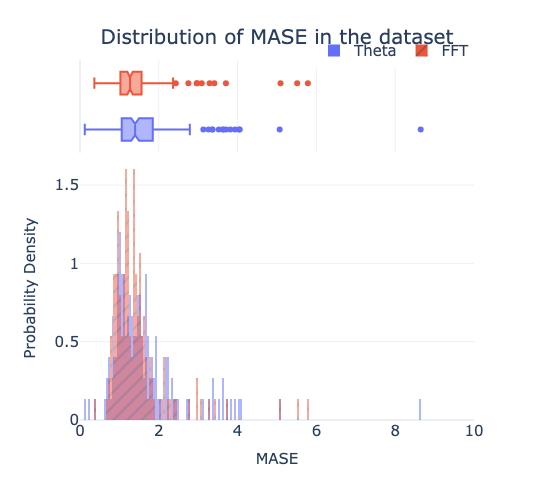

In [50]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,10])
# fig.write_image("imgs/chapter_4/mase_dist.png")
fig.show()

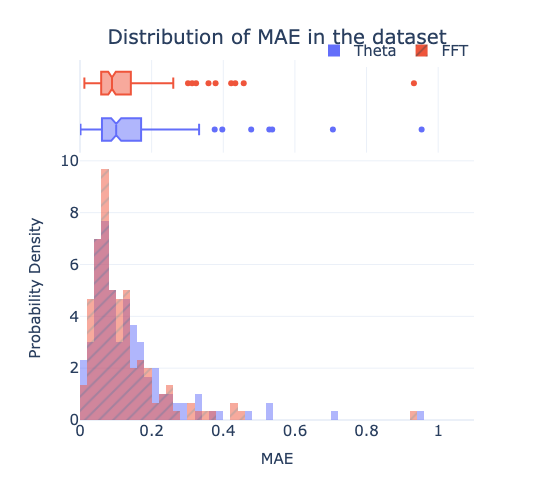

In [51]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
# fig.write_image("imgs/chapter_4/mae_dist.png")
fig.update_layout(xaxis_range=[0,1.1])
fig.show()

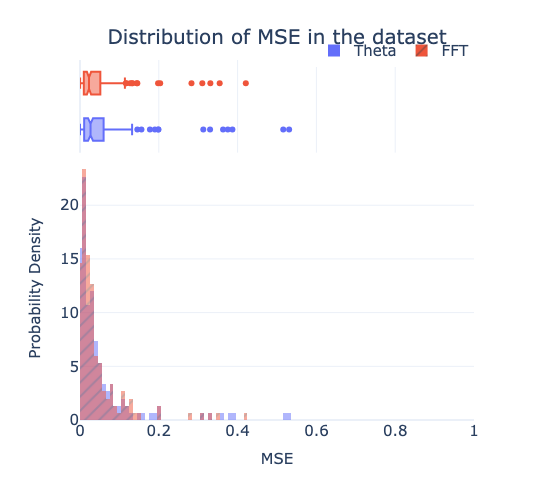

In [52]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,1])
# fig.write_image("imgs/chapter_4/mse_dist.png")
fig.show()

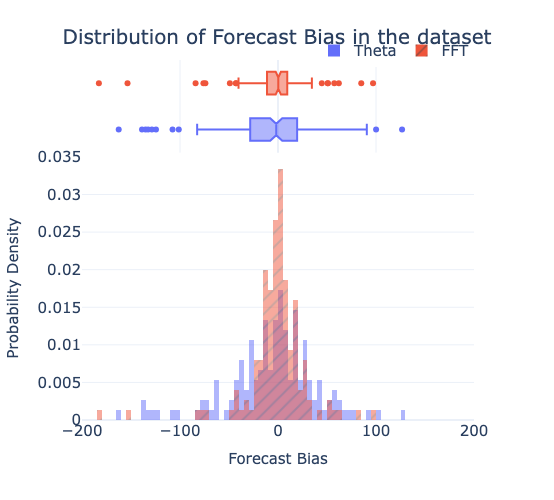

In [53]:
fig = px.histogram(baseline_test_metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-200,200])
# fig.write_image("imgs/chapter_4/bias_dist.png")
fig.show()

### Saving the Baseline Forecasts and Metrics

In [54]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [55]:
baseline_test_pred_df.to_pickle(output/"baseline_test_prediction_df.pkl")
baseline_test_metrics_df.to_pickle(output/"baseline_test_metrics_df.pkl")
agg_test_metrics_df.to_pickle(output/"baseline_test_aggregate_metrics.pkl")